In [46]:


data = pd.read_pickle('../pkl_data/GRAPE.pkl')

import pandas as pd
import numpy as np


def create_lists(df):
    patients = []
    masks = []
    for i, row in df.iterrows():
        visits = []
        mask = []
        for val in row:
            if isinstance(val, float) and pd.isna(val):
                visits.append(np.full_like(df.iloc[0,0], np.nan, dtype=float))
                mask.append(0)
            else:
                visits.append(np.array(val, dtype=float))
                mask.append(1)
        patients.append(np.stack(visits))
        masks.append(np.array(mask, dtype=int))
    return np.array(patients, dtype=float), np.array(masks, dtype=int)




In [53]:
patients, masks = create_lists(data)
patients

array([[[21., 22., 20., ..., 19., 20., 21.],
        [31., 28., 28., ..., 21., 21., 18.],
        [26., 25., 26., ..., 22., 25., 22.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[24., 26., 23., ..., 22., 25., 22.],
        [30., 27., 27., ..., 21., 24., 25.],
        [31., 29., 27., ..., 24., 27., 25.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[31., 30., 29., ..., 17., 18., 25.],
        [26., 28., 28., ..., 25., 16., 27.],
        [30., 29., 28., ..., 22., 22., 23.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[32., 31., 32., ..., 18., 16., 26.],
        [28., 30., 33., ...,  4.,  9., 15.],
        [22., 26., 23., ..., 10., 19., 28.

In [56]:
from sklearn.preprocessing import StandardScaler

flat = patients.reshape(-1, patients.shape[-1])
mask_flat = masks.reshape(-1, 1)


valid_rows = flat[mask_flat[:,0]==1]
scaler = StandardScaler()
scaler.fit(valid_rows)

flat_scaled = scaler.transform(flat)  #NaN are ignored
scaled_patients = flat_scaled.reshape(patients.shape)  #back to normal shape

scaled_patients

array([[[-0.75576311, -0.62462336, -0.7219819 , ...,  0.26373417,
          0.30697575, -0.15611822],
        [ 0.69288029,  0.2841914 ,  0.42210738, ...,  0.50050034,
          0.43272078, -0.65346626],
        [-0.03144141, -0.17021598,  0.13608506, ...,  0.61888343,
          0.93570089,  0.00966446],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[-0.32117009, -0.01874685, -0.29294842, ...,  0.61888343,
          0.93570089,  0.00966446],
        [ 0.54801595,  0.13272228,  0.27909622, ...,  0.50050034,
          0.80995586,  0.5070125 ],
        [ 0.69288029,  0.43566053,  0.27909622, ...,  0.85564961,
          1.18719095,  0.5070125 ],
        ...,
        [        nan,         nan,         nan, ...,  

In [ ]:
from sklearn.decomposition import PCA
N, T, P = patients.shape
n = 7
pca = PCA(n_components=n)
pca.fit(valid_rows)
flat_visits_emb = pca.transform(np.nan_to_num(flat_scaled, nan=0.0))

visit_embeddings = flat_visits_emb.reshape(N, T, n)

diffs = np.diff(visit_embeddings, axis=1)
mean_slope = np.sum(diffs * masks[:,1:,None], axis=1) / np.sum(masks[:,1:], axis=1)[:,None]

mean_embedding = np.sum(visit_embeddings * masks[:, :, None], axis=1) / np.sum(masks, axis=1)[:, None]

# variance_embeddings = np.zeros((N, n))
# for i in range(N):
#     valid_visits = visit_embeddings[i][masks[i]==1]                   not helpful
#     if len(valid_visits) > 1:
#         variance_embeddings[i] = np.var(valid_visits, axis=0)
#     else:
#         variance_embeddings[i] = 0.0


patient_features = np.concatenate([mean_embedding, mean_slope], axis=1)


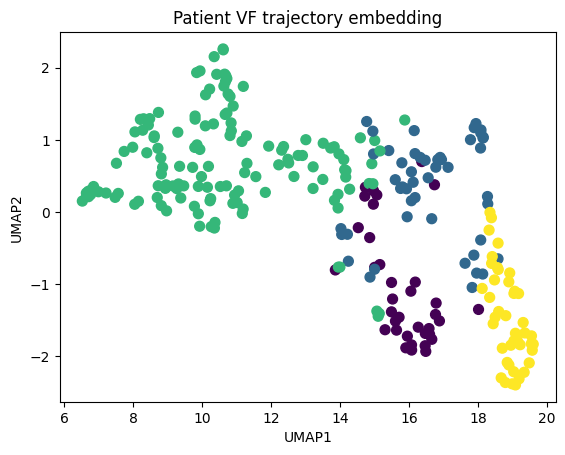

In [264]:
from sklearn.cluster import KMeans
from umap import UMAP
import matplotlib.pyplot as plt

kmeans = KMeans(n_clusters=4)
labels = kmeans.fit_predict(patient_features)

umap = UMAP(n_neighbors=8, min_dist=0.1)
embedding_2d = umap.fit_transform(patient_features)



plt.scatter(embedding_2d[:,0], embedding_2d[:,1], c=labels, s=50)
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.title("Patient VF trajectory embedding")
plt.show()


In [265]:
print(np.unique(labels, return_counts=True))

(array([0, 1, 2, 3], dtype=int32), array([ 36,  48, 137,  42]))


In [266]:
from sklearn.metrics import silhouette_score
score = silhouette_score(patient_features, labels)
print("Silhouette Score:", score)

Silhouette Score: 0.338136773697309


In [267]:
from sklearn.metrics import calinski_harabasz_score
score = calinski_harabasz_score(patient_features, labels)
print("CH Index:", score)

CH Index: 146.41161770222743


n = 7 and 4 clusters. mean_embedding, mean_slope only. Silhouette Score: 0.3003501843879679 and CH Index: 146.31354664512173